# **Customer Data Loader**

Reference: 
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- 

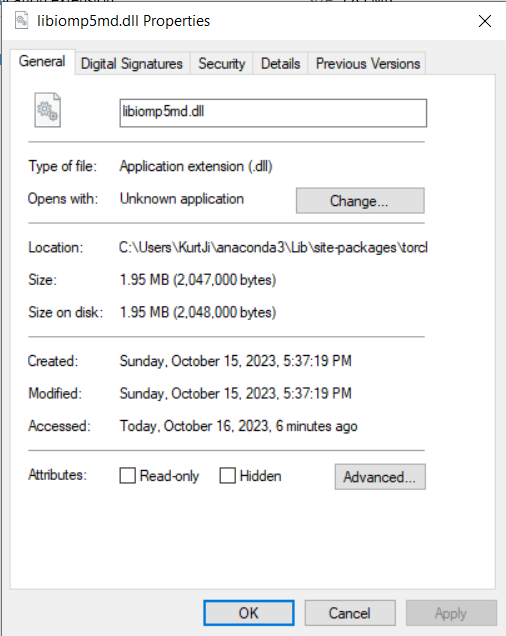
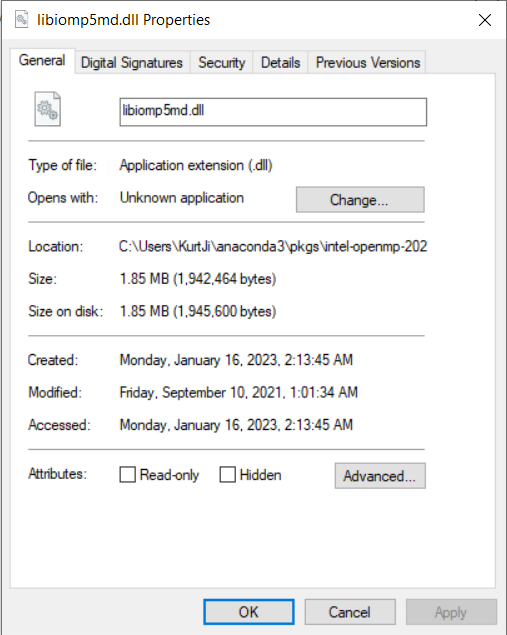
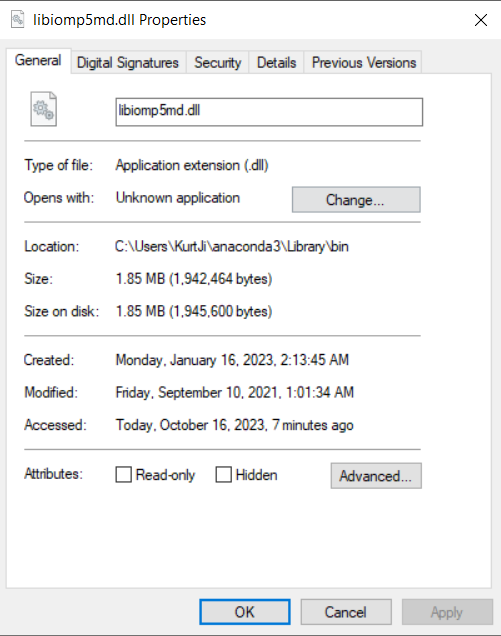
For io errors, read this: https://stackoverflow.com/questions/20554074/sklearn-omp-error-15-initializing-libiomp5md-dll-but-found-mk2iomp5md-dll-a

**Note**: for this data loader I am reading files as csvs that contain image path and annotations.

In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

import ast
import re

import json
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# root path
root_path = 'C:/Users/KurtJi/OneDrive - University of Illinois - Urbana/Desktop/Personal Projects/data/inaturalist/'

**Define Hyper Parameters**

In [30]:
# Hyper parameters
num_epochs = 8
num_classes = 2
batch_size = 256
learning_rate = 0.002

**Check data structure**

In [3]:
mbra_df = pd.read_csv('mbra_dataset.csv')

n = 3833
img_name = mbra_df.iloc[n, 0]
class_name = mbra_df.loc[n, 'class']
common_name = mbra_df.loc[n, 'common_name']

print('Image name: {}'.format(img_name))
print(class_name, common_name)

Image name: train_mini/02989_Animalia_Chordata_Amphibia_Anura_Hylidae_Hyla_gratiosa/c07e2e0a-9eb3-4af5-b4dd-783493d7182e.jpg
Amphibia Barking Tree Frog


**Plot a sample image**

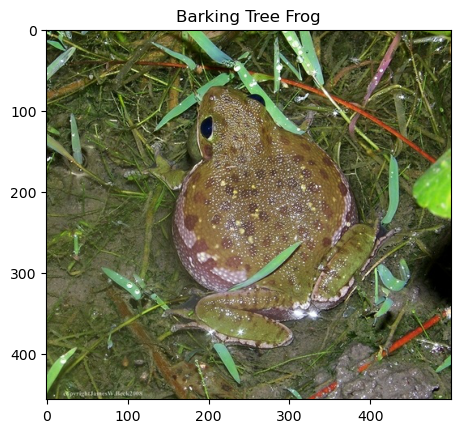

In [4]:
def show_animals(image, label):
    """Show image with label"""
    plt.title(label)
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated
    # Add a title to the plot


plt.figure()
show_animals(io.imread(os.path.join(root_path, img_name)),
               common_name)
plt.show()

### **Dataset Class**

In [42]:
class MbraDataset(Dataset):
    """Face label dataset."""

    def __init__(self, df, root_dir, csv_file=None, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if csv_file:
            self.df = pd.read_csv(csv_file)
        else:
            self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                self.df.iloc[idx, 0])
        # print(img_path)
        image = io.imread(img_path)
        label = self.df.iloc[idx, 1]
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

**Create dataset with class names**

In [6]:
# get the dataframe with only the image and the class level name
mbra_df_class = mbra_df[['image_path', 'class']].copy()

In [7]:
from sklearn import preprocessing

class_labels = mbra_df_class['class'].tolist()

le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(class_labels)

# Create a label map (class_name -> encoded_integer)
class_map = dict(zip(encoded_labels, class_labels))


mbra_df_class['class'] = encoded_labels

mbra_df_class.head()


,image_path,class
0,train_mini/04959_Animalia_Chordata_Reptilia_Sq...,3
1,train_mini/04998_Animalia_Chordata_Reptilia_Sq...,3
2,train_mini/03360_Animalia_Chordata_Aves_Charad...,1
3,train_mini/03533_Animalia_Chordata_Aves_Columb...,1
4,train_mini/04087_Animalia_Chordata_Aves_Passer...,1


In [8]:
class_map

{3: 'Reptilia', 1: 'Aves', 2: 'Mammalia', 0: 'Amphibia'}

0 (375, 500, 3) Reptilia


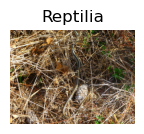

1 (375, 500, 3) Reptilia


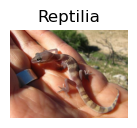

2 (417, 429, 3) Aves


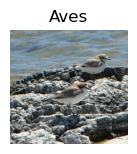

3 (401, 500, 3) Aves


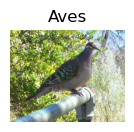

In [9]:
# construct a custom dataset
mbra_data_class = MbraDataset(mbra_df_class,
                                    root_dir=root_path)

fig = plt.figure()

for i, sample in enumerate(mbra_data_class):
    print(i, sample['image'].shape, class_map[sample['label']])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_animals(sample['image'], class_map[sample['label']])

    if i == 3:
        plt.show()
        break


### **Add Transformer**

In [179]:
from sklearn import preprocessing
import torch

In [10]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        # if isinstance(self.output_size, int):
        #     if h > w:
        #         new_h, new_w = self.output_size * h / w, self.output_size
        #     else:
        #         new_h, new_w = self.output_size, self.output_size * w / h
        # else:
        new_h, new_w = self.output_size, self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for label because for images,
        # x and y axes are axis 1 and 0 respectively
        # label = label * [new_w / w, new_h / h]

        return {'image': img, 'label': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        # label = label - [left, top]

        return {'image': image, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.as_tensor((label,))}

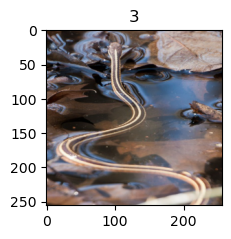

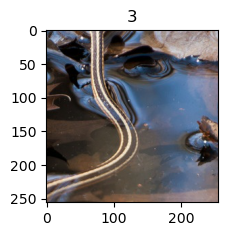

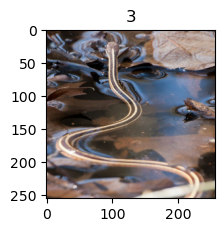

In [11]:
scale = Rescale(256)
crop = RandomCrop(256)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(256)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = mbra_data_class[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_animals(**transformed_sample)

plt.show()

### **Apply Dataloader**

In [12]:
mbra_df_class.head()

,image_path,class
0,train_mini/04959_Animalia_Chordata_Reptilia_Sq...,3
1,train_mini/04998_Animalia_Chordata_Reptilia_Sq...,3
2,train_mini/03360_Animalia_Chordata_Aves_Charad...,1
3,train_mini/03533_Animalia_Chordata_Aves_Columb...,1
4,train_mini/04087_Animalia_Chordata_Aves_Passer...,1


In [13]:
mbra_data_class = MbraDataset(df = mbra_df_class,
                                           root_dir=root_path,
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               ToTensor()
                                           ]))

for i, sample in enumerate(mbra_data_class):
    print(i, sample['image'].size(), sample['label'].size())

    if i == 5:
        break

0 torch.Size([3, 256, 256]) torch.Size([1])
1 torch.Size([3, 256, 256]) torch.Size([1])
2 torch.Size([3, 256, 256]) torch.Size([1])
3 torch.Size([3, 256, 256]) torch.Size([1])
4 torch.Size([3, 256, 256]) torch.Size([1])
5 torch.Size([3, 256, 256]) torch.Size([1])


### **Train/Test Split**

In [20]:
train_size = int(0.8 * len(mbra_data_class))
test_size = len(mbra_data_class) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mbra_data_class, [train_size, test_size])

In [37]:
for i, sample in enumerate(train_dataset):
    print(i, sample['image'].size(), sample['label'].size())

    if i == 5:
        break

0 torch.Size([3, 256, 256]) torch.Size([1])
1 torch.Size([3, 256, 256]) torch.Size([1])
2 torch.Size([3, 256, 256]) torch.Size([1])
3 torch.Size([3, 256, 256]) torch.Size([1])
4 torch.Size([3, 256, 256]) torch.Size([1])
5 torch.Size([3, 256, 256]) torch.Size([1])


In [41]:
train_loader = DataLoader(train_dataset, batch_size=256,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=256//2,
                        shuffle=False, num_workers=0)


In [48]:
len(train_loader)

347

In [29]:
# # Helper function to show a batch
# def show_animal_batch(sample_batched):
#     """Show image with landmarks for a batch of samples."""
#     images_batch, labels_batch = \
#             sample_batched['image'], sample_batched['label']
#     batch_size = len(images_batch)
#     im_size = images_batch.size(2)
#     # grid_border_size = 2

#     grid = utils.make_grid(images_batch)
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))

#     for i in range(batch_size):
#         #print(class_map[int(labels_batch[i])])

#         plt.title('Batch from dataloader')

# # if you are using Windows, uncomment the next line and indent the for loop.
# # you might need to go back and change ``num_workers`` to 0.

# # if __name__ == '__main__':
# for i_batch, sample_batched in enumerate(dataloader):
#     #print(i_batch, sample_batched['image'].size(),
#     #      sample_batched['label'].size())

#     # observe 4th batch and stop.
#     if i_batch == 3:
#         plt.figure()
#         show_animal_batch(sample_batched)
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

# **Building Simple CNN**

#### **Check device**

In [16]:
!conda info --envs

# conda environments:
#
                         C:\Users\KurtJi\AppData\Local\R-MINI~1
                         C:\Users\KurtJi\AppData\Local\R-MINI~1\envs\r-reticulate
                         C:\Users\KurtJi\AppData\Local\r-miniconda
                         C:\Users\KurtJi\anaconda3
                         C:\Users\KurtJi\miniconda3
base                  *  c:\Users\KurtJi\anaconda3



**CUDA+PyTorch Tutorial** https://blog.csdn.net/qq_45956730/article/details/126600028

In [17]:
import torch
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
torch.cuda.is_available()

True

In [19]:
device = torch.cuda.current_device()
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070 Laptop GPU'

### **Model Structure**

In [22]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [32]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [33]:
model = SimpleCNN().to(device)

In [34]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [47]:
# Train the model
total_step = len(train_loader)
print(total_step)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader, 1):
        print(type(images), type(labels))
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

347
<class 'str'> <class 'str'>


AttributeError: 'str' object has no attribute 'to'